In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.io as pio
import json
import ast

In [462]:
theme = None#"Offshore energy impacts on fisheries"
t=None
max_sub = None
depth = None
synonyms= 10
branching = None

param_lst = {'theme':theme,'t':t,'max_sub':max_sub,'depth':depth,'synonyms':synonyms,'':branching}

In [465]:

if None not in param_lst.values():
    topic_data = pd.read_csv(f'Data Generation/Generated Data/{theme}_hierarchy_t{t}_maxsub{max_sub}_depth{depth}_synonyms{synonyms}_{branching}.csv')
    num_seed_topics = len(topic_data['category 0'].unique())

In [466]:
if None not in param_lst.values():
    bertopic_file = f'bertopic_results/results_all_methods_{theme}_hierarchy_t{t}_maxsub{max_sub}_depth{depth}_synonyms{synonyms}_{branching}.csv'
else:
    file_string = "processed_results"
    for key,val in param_lst.items():
        if val is not None:
            file_string += f'_{key}{val}'
    file_string+='.csv'
    bertopic_file = 'bertopic_results/'+file_string
            
bertopic_result_df=pd.read_csv(bertopic_file)

In [491]:
bertopic_result_df.rename(columns={"t": "temp"}, inplace=True)

In [530]:
def analyze_feature_importance(df, target_col, predictor_cols, n_estimators=100, random_state=42, plot_violin=False):
    """
    Trains a Random Forest model to evaluate feature importance and optimal value ranges.
    
    Parameters:
    - df: Pandas DataFrame containing the data
    - target_col: String, name of the target column
    - predictor_cols: List of strings, names of predictor columns
    - n_estimators: Number of trees in the Random Forest (default: 100)
    - random_state: Random seed for reproducibility (default: 42)
    - plot_violin: Boolean, whether to plot violin plots for each predictor (default: False)
    
    Returns:
    - feature_importance: DataFrame with feature importance scores
    - optimal_ranges: Dictionary mapping features to optimal value estimates
    """
    # Keep NaNs in predictors but drop NaNs in the target column
    df = df.dropna(subset=[target_col])
    
    # Separate categorical and numeric columns
    categorical_cols = [col for col in predictor_cols if df[col].dtype == 'object']
    numeric_cols = [col for col in predictor_cols if col not in categorical_cols]
    # Copy dataframe for encoding
    df_encoded = df.copy()
    label_encoders = {}

    # Encode categorical variables (treat NaNs as "Missing")
    for col in categorical_cols:
        df_encoded[col] = df_encoded[col].astype(str).fillna("Missing")  # Convert NaN to string
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le


    # Handle NaNs in numeric columns by replacing them with a placeholder (-99999)
    df_encoded[numeric_cols] = df_encoded[numeric_cols].fillna(-99999)

    # Define features and target
    X = df_encoded[predictor_cols]
    y = df[target_col]
    
    # Train Random Forest model
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)
    
    # Compute feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance in Random Forest')
    plt.show()
    
    # Compute optimal ranges for features
    optimal_ranges = {}

    for feature in predictor_cols:
        feature_vals = np.sort(df_encoded[feature].dropna().unique())  # Sorted unique values from encoded df
        if len(feature_vals) == 0:
            optimal_ranges[feature] = None
            continue
        
        pred_vals = [rf.predict(X[df_encoded[feature] == val]) for val in feature_vals]
        max_pred_idx = np.argmax([np.mean(pred) for pred in pred_vals])
        optimal_value = feature_vals[max_pred_idx]

        # Decode categorical variables back to original values
        if feature in label_encoders:
            optimal_value = label_encoders[feature].inverse_transform([optimal_value])[0]
        
        optimal_ranges[feature] = optimal_value
    # Optionally plot violin plots
    if plot_violin:
        for feature in predictor_cols:
            plt.figure(figsize=(10, 5))
            if feature in categorical_cols:
                df_plot = df.copy()
                df_plot[feature] = df_plot[feature].astype(str).fillna("Missing")  # Keep NaNs as "Missing"
                sns.violinplot(x=df_plot[feature], y=target_col, data=df_plot)
            else:
                df_plot = df.copy()
                df_plot[feature] = df_plot[feature].fillna('None')  # Keep NaNs explicitly
                sns.violinplot(x=df_plot[feature].astype(str), y=target_col, data=df_plot)
            
            plt.title(f'Distribution of {target_col} by {feature}')
            plt.xlabel(feature)
            plt.ylabel(target_col)
            plt.xticks(rotation=45)
            plt.show()
    
    return feature_importance, optimal_ranges

def filter_and_expand(df, category, filter_val):
    """
    Filters the DataFrame based on a specific value in the given method column
    and expands the dictionary in the corresponding params column into separate columns.
    
    :param df: DataFrame to process
    :param category: Either 'reduction' or 'cluster' to specify which method to filter
    :param filter_val: Value to filter for
    :return: Processed DataFrame
    """
    method_col = f"{category}_method"
    params_col = f"{category}_params"
    
    # Filter the DataFrame
    filtered_df = df[df[method_col] == filter_val].copy()
    
    # Convert string dictionaries to actual dictionaries (if necessary)
    if filtered_df[params_col].dtype == 'object':
        filtered_df[params_col] = filtered_df[params_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Expand the parameters dictionary into separate columns
    params_df = filtered_df[params_col].apply(pd.Series)
    print(params_df)
    # Concatenate the expanded parameters with the original DataFrame
    filtered_df = pd.concat([filtered_df.drop(columns=[params_col]), params_df], axis=1)
    
    return filtered_df, params_df.columns


#### Plot Embeddings

In [520]:
# ndim=optimal_ranges['ndim']
# knn=optimal_ranges['knn']
# decay=optimal_ranges['decay']
# pca = int(optimal_ranges['pca'])

# Y_phate =np.load(f'phate_embed_results_{theme}_hierarchy_t{t}_maxsub{max_sub}_depth{depth}_synonyms{synonyms}/phate_embed_ndim_{ndim}_knn_{knn}_decay_{decay}_pca_{pca}.npy'
# )

In [511]:

# fig_file  =f'phate_result_plots/plot_{theme}_hierarchy_t{t}_maxsub{max_sub}_depth{depth}_synonyms{synonyms}_ndim_{ndim}_knn_{knn}_decay_{decay}_pca_{pca}.png'

# fig = px.scatter_3d(x=Y_phate[:,0], y=Y_phate[:,1], z=Y_phate[:,2], hover_data=[np.array(topic_data["topic"]),np.array(topic_data['category 0'])], width=1100, height=800,
#                    color=np.array(topic_data['category 0']))
# fig.show() 

# # pio.write_image(fig, fig_file, scale=5)

### Bertopic

###### Compare Methods

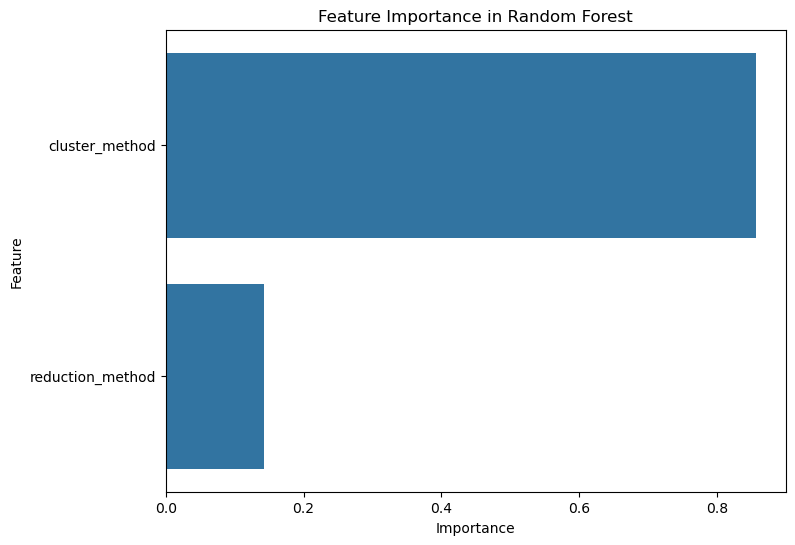

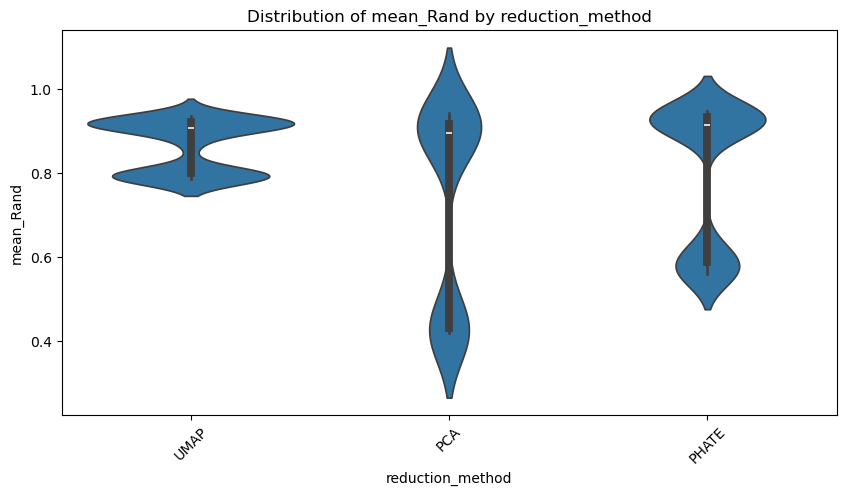

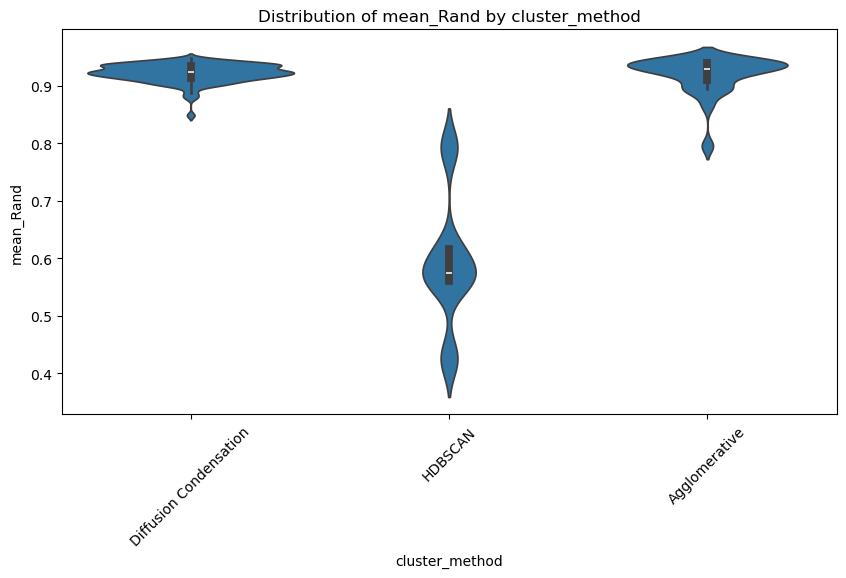

In [532]:
score = 'Rand'
bertopic_result_df[f'mean_{score}'] = bertopic_result_df.groupby(['reduction_method', 'cluster_method', 'reduction_params', 'cluster_params'])[f'{score}'].transform('mean')
feature_importance, optimal_ranges = analyze_feature_importance(bertopic_result_df, f'mean_{score}',['reduction_method',	'cluster_method'], plot_violin=True)

In [533]:
df_param,cols = filter_and_expand(bertopic_result_df, 'reduction', 'PHATE')

      decay  n_components     t
320      20           100  auto
321      20           100  auto
322      20           100  auto
323      20           100  auto
324      20           100  auto
...     ...           ...   ...
1659     30           300    11
1660     30           300    11
1661     30           300    11
1662     30           300    11
1663     30           300    11

[1024 rows x 3 columns]


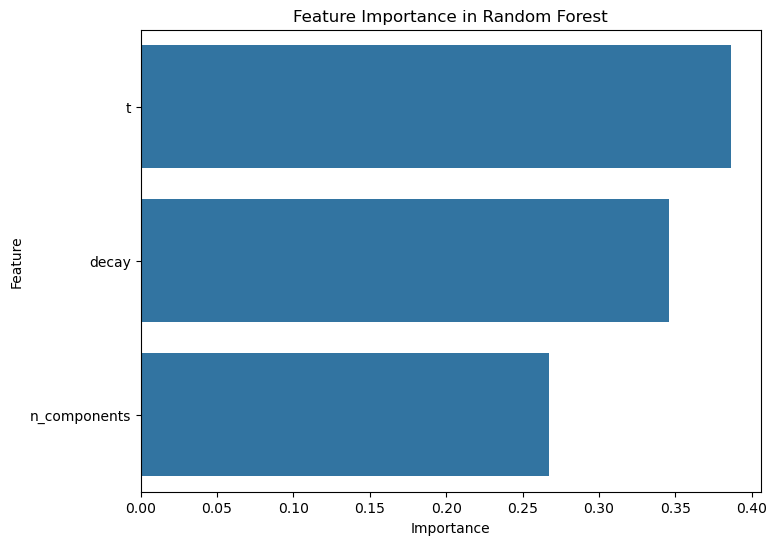

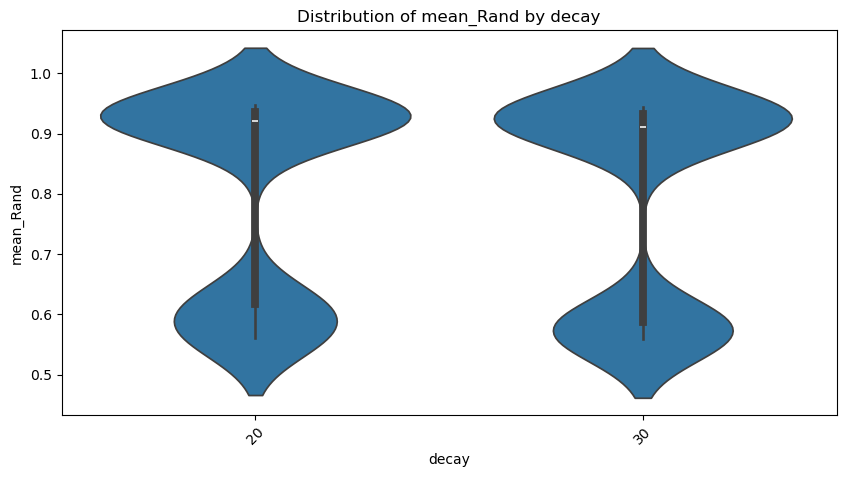

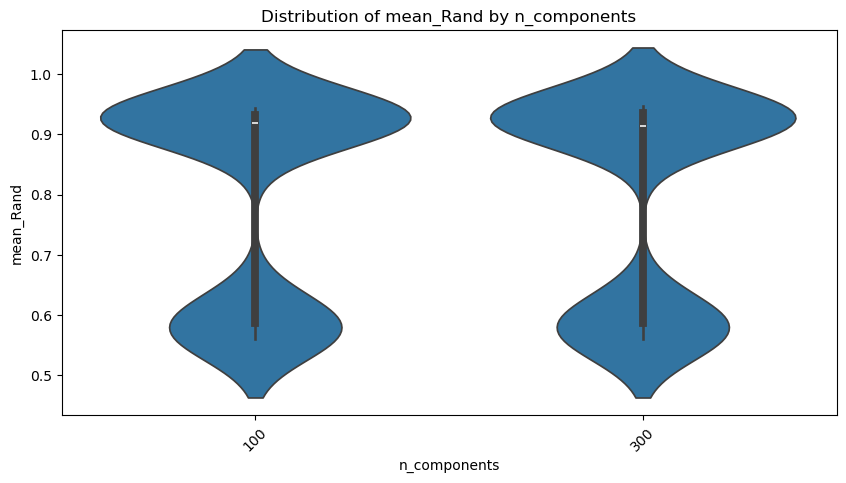

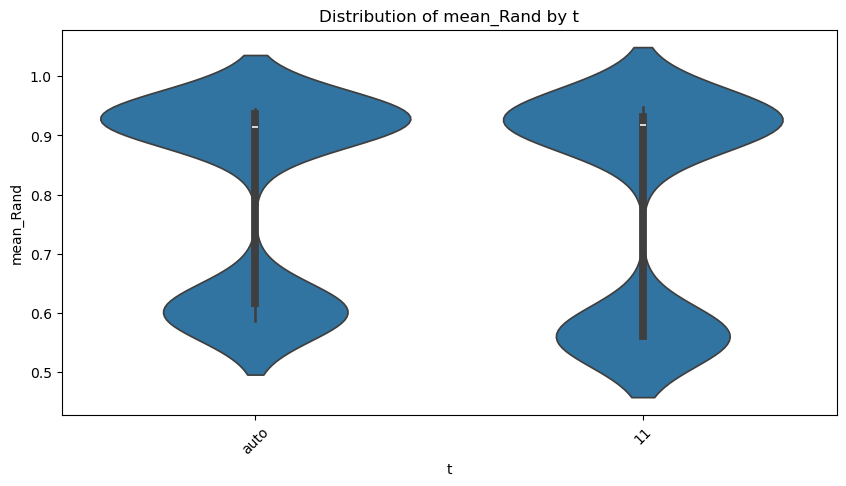

{'decay': 20, 'n_components': 300, 't': 'auto'}

In [534]:
feature_importance, optimal_ranges = analyze_feature_importance(df_param, f'mean_{score}',cols, plot_violin=True)
optimal_ranges

#### Nate's Results

In [115]:
def process_results(file_name):
    """
    Reads a JSON file containing clustering results and converts it into a structured DataFrame.
    
    Parameters:
    file_name (str): Path to the JSON file.
    
    Returns:
    pd.DataFrame: Processed DataFrame with parameters and scores.
    """
    with open(file_name, 'r') as f:
        results = json.load(f)
    
    df_records = []
    for entry in results:
        record = {}
        
        # Extract params
        params = entry["params"]
        record["alpha"] = params["alpha"]
        record["bandwidth_norm"] = params["bandwidth_norm"]
        record["k"] = params["k"]
        record["t"] = params["t"]
        record["phate_decay"] = params["phate"]["decay"]
        record["phate_knn"] = params["phate"]["knn"]
        record["phate_n_components"] = params["phate"]["n_components"]
        record["phate_t_phate"] = params["phate"]["t_phate"]

        # Extract scores
        for metric in ["FM", "Rand", "adjusted_Rand"]:
            for key, value in entry[metric].items():
                col_name = f"ARI_{key}" if metric == "adjusted_Rand" else f"{metric}_{key}"
                record[col_name] = value

        df_records.append(record)
    
    return pd.DataFrame(df_records)


In [117]:
file_name = 'results_Offshore energy impacts on fisheries_hierarchy_t1.0_maxsub3_depth5_synonyms0_gpt_embed_20250328_191816.json'
df_results = process_results(file_name)

In [118]:
cols = ['alpha',	'bandwidth_norm',	'k'	,'t'	,'phate_decay',	'phate_knn',	'phate_n_components',	'phate_t_phate']
score = 'ARI'

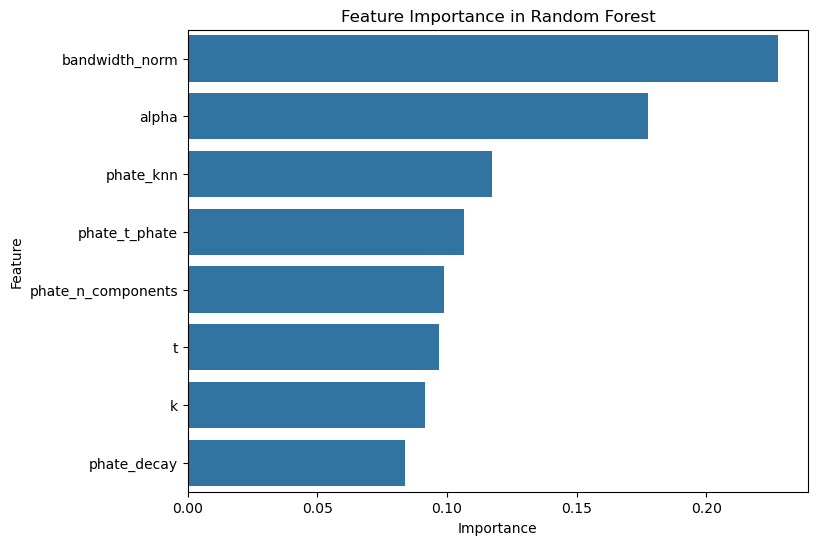

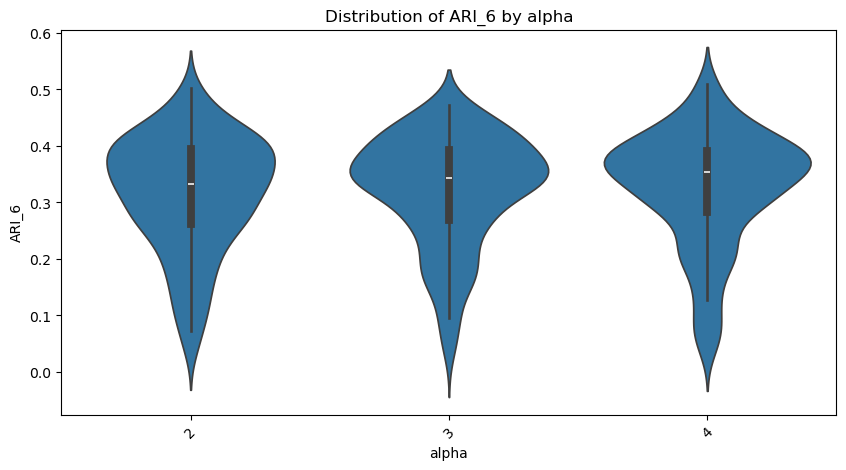

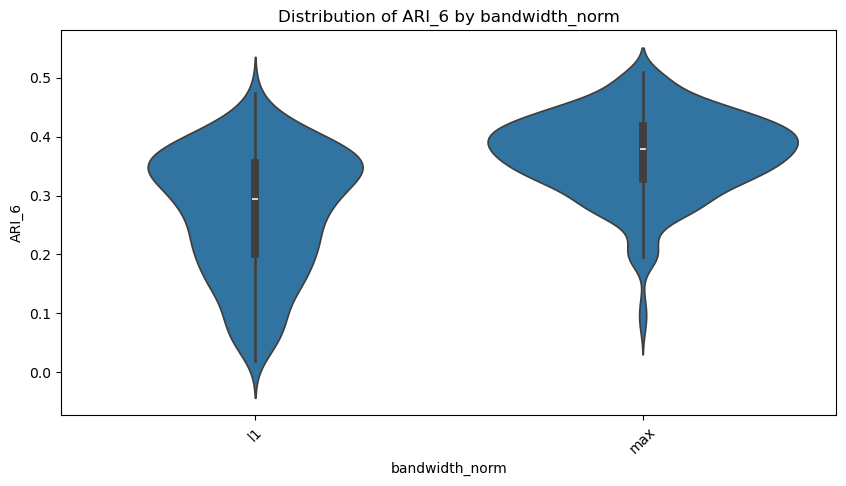

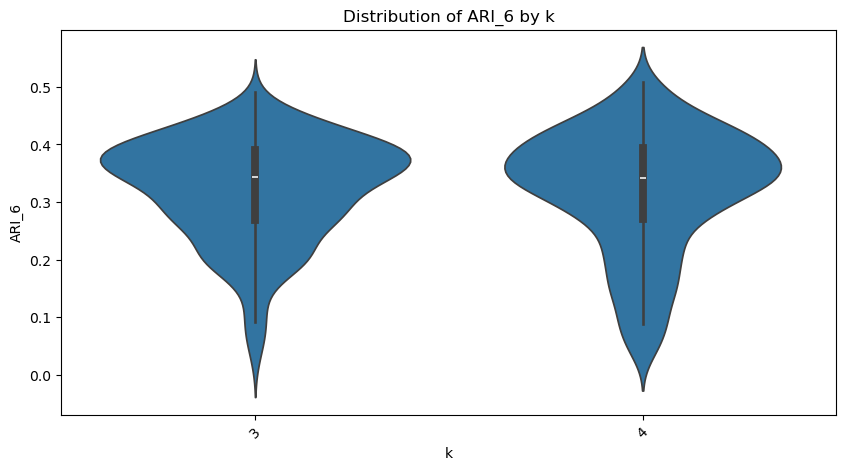

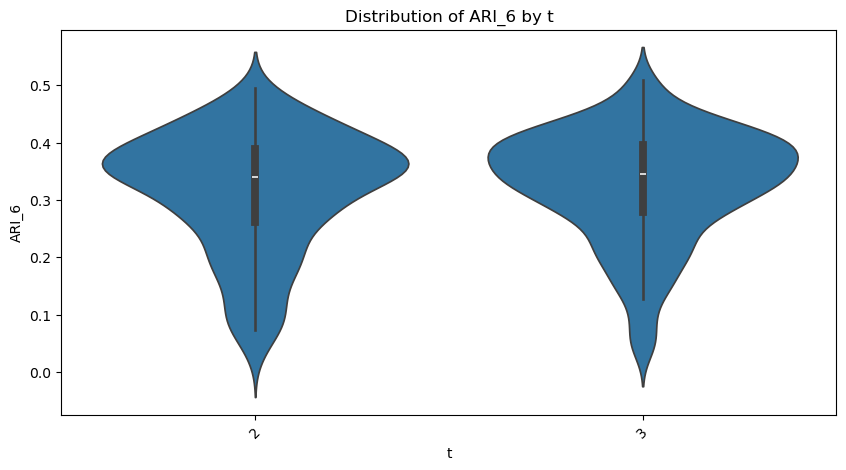

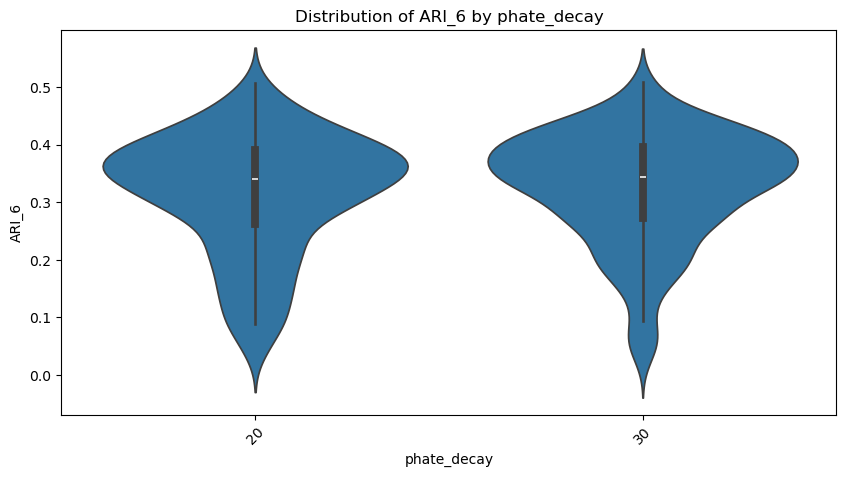

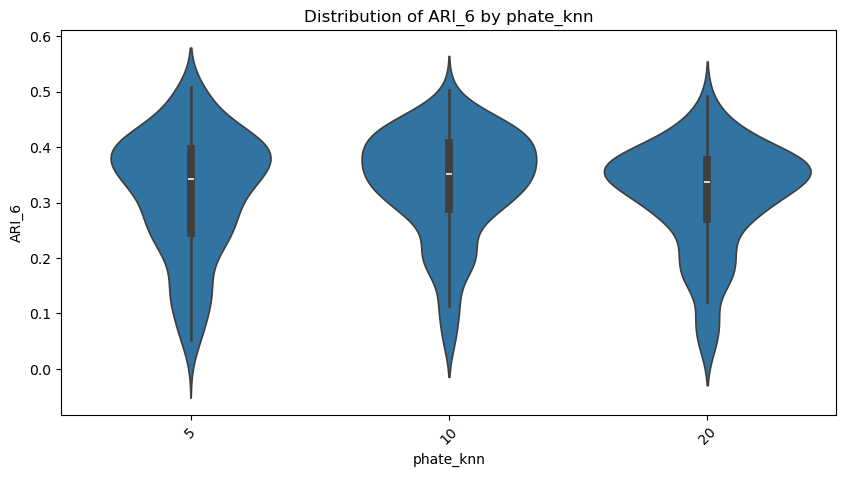

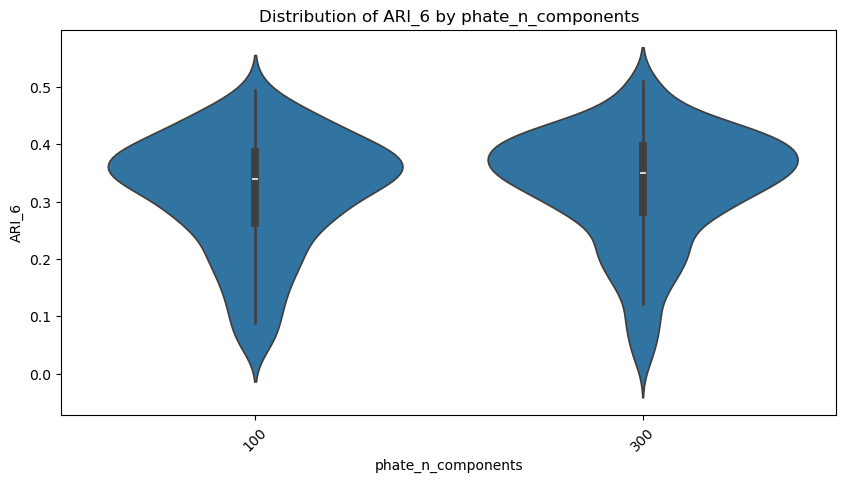

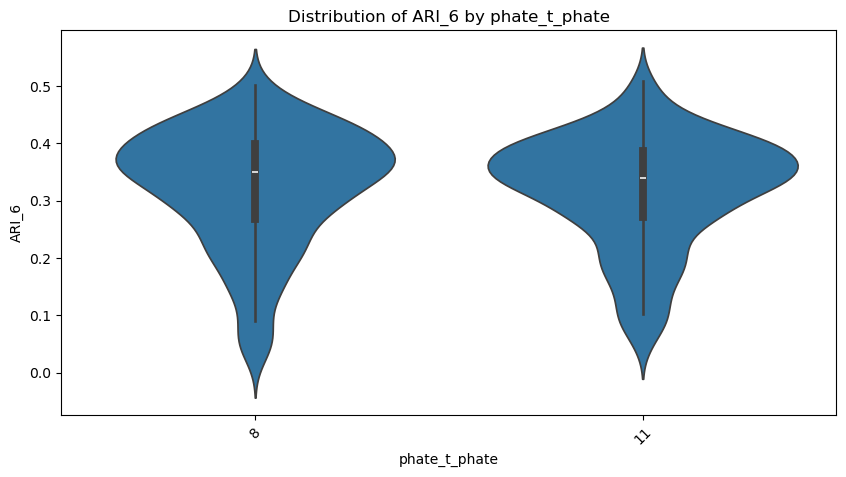

{'alpha': 4,
 'bandwidth_norm': 'max',
 'k': 3,
 't': 3,
 'phate_decay': 30,
 'phate_knn': 10,
 'phate_n_components': 300,
 'phate_t_phate': 8}

In [119]:
feature_importance, optimal_ranges = analyze_feature_importance(df_results, f'{score}_6',cols, plot_violin=True)
optimal_ranges

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Adjusted Rand Index (ARI): 0.7241
Rand Index (RI): 0.9470
Fowlkes-Mallows Index (FMI): 0.7556


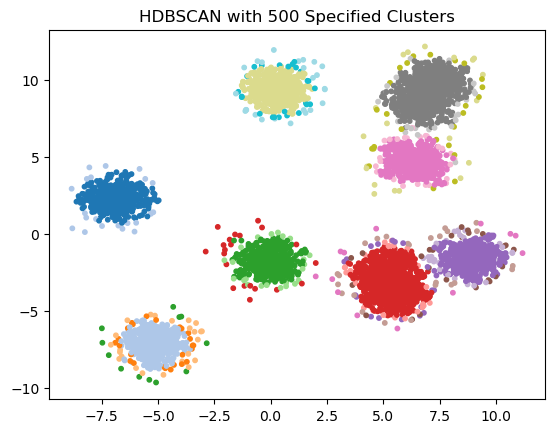

In [429]:
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score, rand_score

# Generate synthetic data
X, y_true = make_blobs(n_samples=5000, centers=10, cluster_std=.75, random_state=9032211)

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN()
clusterer.fit(X)

# Extract the single linkage tree
Z = clusterer.single_linkage_tree_.to_numpy()

# Specify the desired number of clusters
desired_clusters = 500 #500

# Use fcluster to extract the desired number of clusters
flat_clusters = fcluster(Z, desired_clusters, criterion='maxclust')

# Compute evaluation metrics
ari = adjusted_rand_score(y_true, flat_clusters)
fmi = fowlkes_mallows_score(y_true, flat_clusters)
ri = rand_score(y_true, flat_clusters)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Rand Index (RI): {ri:.4f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")


# Plot results
plt.scatter(X[:, 0], X[:, 1], c=flat_clusters, cmap='tab20', s=10)
plt.title(f"HDBSCAN with {desired_clusters} Specified Clusters")
plt.show()

Adjusted Rand Index (ARI): 0.8887
Rand Index: 0.9800
Fowlkes-Mallows Index (FMI): 0.8998


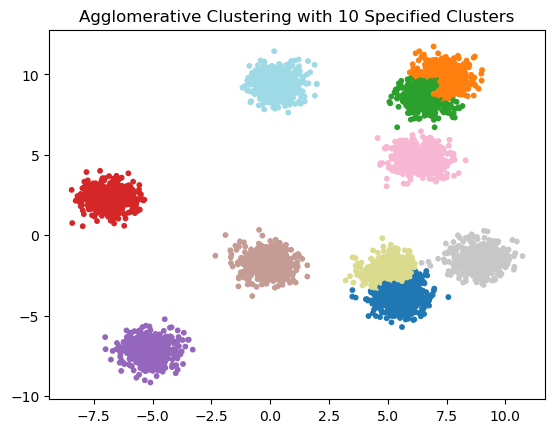

In [395]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, rand_score, fowlkes_mallows_score

# Generate synthetic data
X, y_true = make_blobs(n_samples=5000, centers=10, cluster_std=0.6, random_state=9032211)

# Perform hierarchical clustering using AgglomerativeClustering
desired_clusters = 10
agg_clusterer = AgglomerativeClustering(n_clusters=desired_clusters, linkage='ward')
labels = agg_clusterer.fit_predict(X)

# Calculate clustering metrics
ari_score = adjusted_rand_score(y_true, labels)
rand_index = rand_score(y_true, labels)
fmi_score = fowlkes_mallows_score(y_true, labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Rand Index: {rand_index:.4f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi_score:.4f}")

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab20', s=10)
plt.title(f"Agglomerative Clustering with {desired_clusters} Specified Clusters")
plt.show()